In [2]:
import os
import numpy as np
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from time import time
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim

from torch.utils.tensorboard import SummaryWriter

from functools import reduce

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataloader + downloading dataset

In [80]:
DOWNLOAD = False
TRAIN_VAL_SPLIT = 0.9
batch_size = 64

root = './resources/mnist'
if not os.path.exists(root):
    os.mkdir(root)
    
transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.0,), (1.0,))
                               ])

# Flatten the images into a vector
flatten = lambda x: transforms.ToTensor()(x).view(28**2)

train_set = datasets.MNIST(root=root, download=DOWNLOAD, train=True, transform=transform)
test_set = datasets.MNIST(root=root, download=DOWNLOAD, train=False, transform=transform)

# The digit classes to use
# classes = [0,1,2,3,4,5,6,7,8,9]
classes = [3,4]

def stratified_sampler(labels, classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           sampler=stratified_sampler(train_set.train_labels, classes),
#                                            shuffle=True
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          sampler=stratified_sampler(test_set.test_labels, classes)
#                                           shuffle=False
                                         )

ones_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          sampler=stratified_sampler(test_set.test_labels, [1])
                                         )

print('Training samples: {}'.format(len(train_set)))
print('Test samples: {}'.format(len(test_set)))

Training samples: 60000
Test samples: 10000


/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
len(train_set.indices), len(train_loader)

## Inspecting the first iteration of images and labels

In [6]:
# get iteration of images and labels to find out its shape
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [7]:
# Minimum and maximum value in the first image (pixel range)
min(images[0].view(-1)), max(images[0].view(-1))

(tensor(0.), tensor(0.9961))

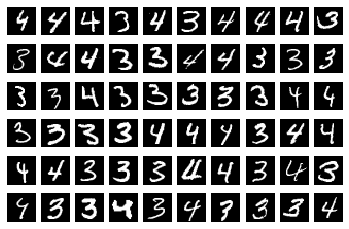

In [8]:
# display 60 images from current iteration
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gist_gray')

# Classifier network

In [306]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_features = 28*28
out_conv_size = 4*4*16
output_size = 2

class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2d = nn.Dropout2d()
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(out_conv_size, 256)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)
        
    def forward(self, x):
#         x = x.view(x.shape[0], -1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, out_conv_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
#         x = x / 100
        x = F.softmax(self.fc3(x))
#         x = self.fc3(x)
        return x
    
net = Classifier().to(device)
print(net)

Classifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [307]:
import torch.optim as optim

# loss_function = nn.MSELoss()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Test the forward pass

In [308]:
# test the forward pass
images, labels = next(iter(train_loader))
images = images.to(device)
print(images.shape)
outputs = net(images)
print(outputs.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 2])
torch.Size([64])


/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [309]:
# min and max value of output images (pixel values)
min(outputs.view(-1)), max(outputs.view(-1))

(tensor(0.4732, grad_fn=<SelectBackward>),
 tensor(0.5268, grad_fn=<SelectBackward>))

In [310]:
# Example loss function and output dimensions
loss = loss_function(outputs, labels-3)
print('loss value:', loss)

loss value: tensor(0.6941, grad_fn=<NllLossBackward>)


## Train the network

In [311]:
from IPython.display import Image, display, clear_output
# train the network
TF_LOG = False
train_loss = []
valid_loss = []

print("Using device:", device)

if TF_LOG:
    tb = SummaryWriter()

for epoch in range(20):
    batch_loss, batch_kl = [], []
    net.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_function(outputs, labels-3)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    train_loss.append(np.mean(batch_loss))
    
    with torch.no_grad():
        net.eval()
        batch_loss = []
        
#         for data in test_loader:
        data = next(iter(test_loader))
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)

        loss = loss_function(outputs, labels-3)
        batch_loss.append(loss.item())
            
        valid_loss.append(np.mean(batch_loss))
        
    if TF_LOG:
        tb.add_scalar('Training loss', train_loss[-1], epoch)
        tb.add_scalar('Validation loss', valid_loss[-1], epoch)

#     tb.add_scalar('Number Correct', total_correct, epoch)
#     tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

#     tb.add_histogram('encoder.bias', network.encoder.bias, epoch)
#     tb.add_histogram('encoder.weight', network.encoder.weight, epoch)
#     tb.add_histogram('encoder.weight.grad', network.encoder.weight.grad, epoch)
#     tb.add_histogram('decoder.bias', network.decoder.bias, epoch)
#     tb.add_histogram('decoder.weight', network.decoder.weight, epoch)
#     tb.add_histogram('decoder.weight.grad', network.decoder.weight.grad, epoch)


if TF_LOG:
    tb.close()
print('Finished training!')

Using device: cpu


/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 0.633
[2,   100] loss: 0.331
[3,   100] loss: 0.325
[4,   100] loss: 0.322
[5,   100] loss: 0.322
[6,   100] loss: 0.321
[7,   100] loss: 0.319
[8,   100] loss: 0.320
[9,   100] loss: 0.318
[10,   100] loss: 0.318
[11,   100] loss: 0.318
[12,   100] loss: 0.317
[13,   100] loss: 0.316
[14,   100] loss: 0.317
[15,   100] loss: 0.316
[16,   100] loss: 0.317
[17,   100] loss: 0.316
[18,   100] loss: 0.316
[19,   100] loss: 0.316
[20,   100] loss: 0.316
Finished training!


## Save trained model

In [263]:
PATH = './models/3-4_classifier_conv.pth'
torch.save(net.state_dict(), PATH)

### Train & validation loss

[Text(0, 0.5, 'loss'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Training & validation loss')]

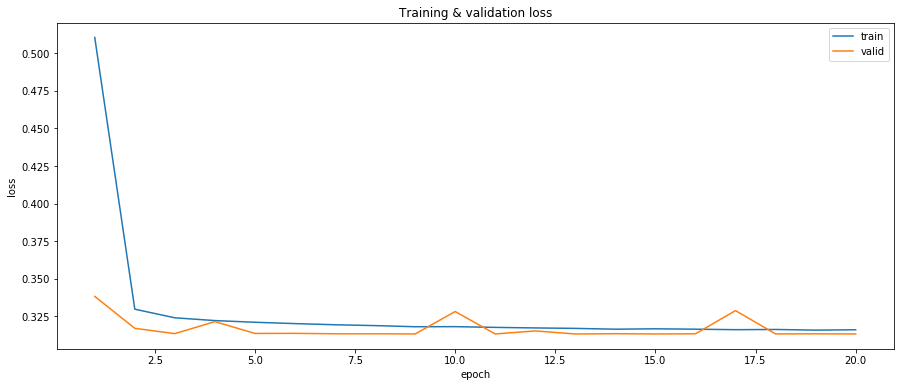

In [312]:
net.eval()

f, ax = plt.subplots(1, figsize=(15, 6))
x = range(1, epoch + 2)
sns.lineplot(x=x, y=train_loss, ax=ax, label="train")
sns.lineplot(x=x, y=valid_loss, ax=ax, label="valid")
ax.set(xlabel="epoch",
       ylabel="loss",
       title="Training & validation loss")

In [255]:
# get iteration of images and labels to find out its shape
dataiter = iter(test_loader)
images, labels = dataiter.next()

# display 60 images from current iteration
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gist_gray')

## Test the network

In [ ]:
net = Classifier()
PATH = './models/3-4_classifier_conv.pth'
net.load_state_dict(torch.load(PATH))

In [313]:
correct = 0
total = 0
out_data = []

with torch.no_grad():
    net.eval()
    for images, labels in test_loader:
        outputs = net(images)
        predicted = outputs.max(dim=1)[1] + 3
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        out_data.append(outputs.numpy())

out_data = np.vstack(out_data)
print(f"Accuracy on the test set: {100*correct/total} %")

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy on the test set: 99.84939759036145 %


In [314]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    net.eval()
    for images, labels in test_loader:
        labels -= 3
        outputs = net(images)
        predicted = outputs.max(dim=1)[1]
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of class %5s : %f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of class     3 : 99.702970 %
Accuracy of class     4 : 100.000000 %


In [315]:
min(out_data.max(axis=1))

0.9093367

In [316]:
# ones_iter = iter(test_loader)
ones_iter = iter(ones_loader)
ones_images, ones_labels = next(ones_iter)
ones_images[0].shape
len(ones_images)

64

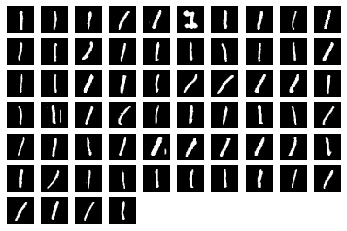

In [317]:
for i in range(len(ones_images)):
    plt.subplot(7, 10, i+1)
    plt.axis('off')
    plt.imshow(ones_images[i].numpy().squeeze(), cmap='gist_gray')

In [318]:
with torch.no_grad():
    net.eval()
    ones_outputs = net(ones_images)
    print(ones_outputs)
    print('max class prediction:', ones_outputs.max(dim=1))
    print('total max certain prediction:', max(ones_outputs.max(dim=1)[0]))

tensor([[9.9795e-01, 2.0492e-03],
        [9.9462e-01, 5.3770e-03],
        [9.9751e-01, 2.4915e-03],
        [6.8039e-01, 3.1961e-01],
        [9.9621e-01, 3.7869e-03],
        [1.0000e+00, 1.4391e-09],
        [9.9762e-01, 2.3787e-03],
        [9.9611e-01, 3.8877e-03],
        [9.7948e-01, 2.0523e-02],
        [9.9465e-01, 5.3499e-03],
        [9.8639e-01, 1.3605e-02],
        [9.9543e-01, 4.5659e-03],
        [9.9732e-01, 2.6765e-03],
        [9.8586e-01, 1.4137e-02],
        [9.9835e-01, 1.6528e-03],
        [9.9306e-01, 6.9438e-03],
        [9.8801e-01, 1.1989e-02],
        [9.9071e-01, 9.2890e-03],
        [9.9371e-01, 6.2893e-03],
        [9.7861e-01, 2.1392e-02],
        [9.8608e-01, 1.3919e-02],
        [9.9310e-01, 6.9023e-03],
        [9.9582e-01, 4.1824e-03],
        [9.9546e-01, 4.5353e-03],
        [9.9621e-01, 3.7912e-03],
        [9.4156e-01, 5.8437e-02],
        [9.7700e-01, 2.2998e-02],
        [9.9224e-01, 7.7570e-03],
        [8.9520e-01, 1.0480e-01],
        [9.952

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Compare predictions for classes from test set (similar distribution to training) and predictions of different (unseen) class:

In [319]:
with torch.no_grad():
    net.eval()
    batch_3s4s, _ = next(iter(test_loader))
    pom_3s4s = net(batch_3s4s)
    batch_ones, _ = next(iter(ones_loader))
    pom_ones = net(batch_ones)

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [320]:
# pom_ones = ones_outputs
# pom_ones.shape
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].scatter(x = pom_ones[:,0], y = pom_ones[:,1])
ax[0].set_title('Class predictions for batch of 1s (softmaxed)')
ax[0].set_xlabel('class 3')
ax[0].set_ylabel('class 4')

ax[1].scatter(x = pom_3s4s[:,0], y = pom_3s4s[:,1])
ax[1].set_title('Class predictions for batch of 3s and 4s (softmaxed)')
ax[1].set_xlabel('class 3')
ax[1].set_ylabel('class 4')

Text(0, 0.5, 'class 4')